## <center>Midterm Lab
```
- Advanced Machine Learning, Innopolis University 
- Professor: Muhammad Fahim 
- Teaching Assistant: Gcinizwe Dlamini
```
<hr>

```
Tasks:
  1. Image Transform (5 points)
  2. CNN model declaration (10 points)
  3. CNN model training (5 points)
  4. Transfer Learning or Viterbi algorithm : Bonus (5 points)
```

<hr>

## The Dataset

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim

import numpy as np

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Task 1 : Preprocessing of Dataset (5 points)

1.   Create the transforms:
    * Resize images to (32 * 32)
    * Normalize every channel (mean and std of your choice)
    * Apply one more data augmentation technique you know (i.e Rotation, translation, RandomErasing, RandomHorizontalFlip etc.)


**Hint**: data augmentation techniques shouldn't be applied to the test dataset.

In [57]:
transform_train = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Resize((32, 32),),
        transforms.RandomErasing(), # Added some augmentation
        transforms.ColorJitter(
            brightness=63.0 / 255.0, saturation=[0.5, 1.5], contrast=[0.2, 1.8]
        ),
        transforms.Normalize(
            (0.4376821, 0.4437697, 0.47280442), (0.19803012, 0.20101562, 0.19703614),
        ),
    ]
)

transform_test = None 

trainset = torchvision.datasets.SVHN(root='./data/train', split="train", download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=1)

testset = torchvision.datasets.SVHN(root='./data/test', split="test", download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False, num_workers=1)

classes = [f"{i}" for i in np.unique(trainset.labels)]

Using downloaded and verified file: ./data/train/train_32x32.mat
Using downloaded and verified file: ./data/test/test_32x32.mat


## Task 1.1 Plot Classes distribution 

Plot the distribution of classes in the training sample on a bar graph

(array([ 4948., 13861., 10585.,  8497.,  7458.,  6882.,  5727.,  5595.,
         5045.,  4659.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <a list of 10 Patch objects>)

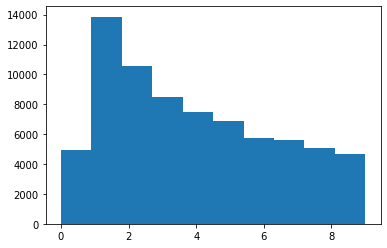

In [58]:
from matplotlib import pyplot as plt
from collections import Counter
#TODO: Plot the distribution of classes
plt.hist(trainset.labels)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


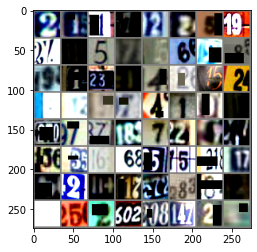

In [59]:
def to_img(x):
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    x = x.view(x.size(0), 3, 32, 32)
    return x

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5 # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# sample a batch and show 
dataiter = iter(trainloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))

import torch.nn as nn## Task 2 : Build a classisfication convolutional neural network


The Model should should have the following achitecture : 
1. 3 Convolution layers : (5 points)
    * conv1 : 2 kernels, 3*3 kernel size, stride 1.
    * conv2 : 4 kernels, 5*5 kernel size, stride 2.
    * conv3 : 8 kernels, 3*3 kernel size, stride 1.
    * Add 1 Avarage pooling layer after 2nd layer and 1 Max-pooling layer before the fully connected layers.
    * Stride for all pooling operations set to 1 
    
    
2. Fully connected layers : 
    * fc1 : 64 output-neurons with a relu activation.
    * output_layer : final layer with no activation function
    * Add Dropout layer after the first (fc1) layer with 25% dropout probability

3. Implement the foward pass method for the CNN  (5 points)
    * Add an activation function of your own choice after every layer
    

In [145]:
import torch.nn as nn

class Net(nn.Module):
    def __init__(self, output_num):
        super(Net, self).__init__()
        #TODO: Declare the model layers
        self.conv1 = nn.Conv2d(3, 2, kernel_size=3, stride=1)
        self.conv2 = nn.Conv2d(2, 4, kernel_size=5, stride=2)
        self.conv3 = nn.Conv2d(4, 8, kernel_size=3, stride=1)
        self.fc1 = nn.Linear(648, 64)
        self.fc2 = nn.Linear(64, output_num)
        self.maxpool = nn.MaxPool2d(2, stride=1)
        self.averagepool = nn.AvgPool2d(2, stride=1)
        self.flatten = nn.Flatten()

    def forward(self, x):
        # TODO: Implement the forward pass
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.averagepool(x)
        x = self.conv3(x)
        x = self.maxpool(x)
        x = self.flatten(x)
        x = nn.ReLU()(self.fc1(x))
        x = self.fc2(x)
        return x

## Task 3 : Convolutional neural network training precedure (5 points)

Implement the model training procedure and select the appropriate loss function

In [152]:
# Model accuracy calculator 
def accuracy_calc(net,testloader,device):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            predicted = torch.ceil(torch.nn.Sigmoid()(predicted))
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    return correct / total

In [153]:
model = Net(len(classes)).to(device)
model

Net(
  (conv1): Conv2d(3, 2, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(2, 4, kernel_size=(5, 5), stride=(2, 2))
  (conv3): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=648, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=10, bias=True)
  (maxpool): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  (averagepool): AvgPool2d(kernel_size=2, stride=1, padding=0)
  (flatten): Flatten(start_dim=1, end_dim=-1)
)

In [154]:
#Set hyper parameters 
nb_epoch = 3
lr = 0.001

optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
criterion = nn.CrossEntropyLoss() #TODO: Define the Loss function (criterion)

def train(model,trainloader,optimizer, criterion, device):
    #TODO : Implement the training procedure of the model at each an every epoch. It should return model loss and accuracy on training sample
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch in trainloader:

      inputs, labels = batch
      inputs = inputs.to(device)
      labels = labels.to(device)

      optimizer.zero_grad()
      predictions = model(inputs)
      loss = criterion(predictions, labels)

      acc = accuracy_calc(model, trainloader, device)
      
      loss.backward()
      optimizer.step()
      
      epoch_loss += loss.item()
      epoch_acc += acc
      
      return epoch_loss , epoch_acc 

In [155]:
for epoch in range(nb_epoch):
    epochLoss, epochAcc = train(model,trainloader, optimizer, criterion, device)
    print(f"Epoch : {epoch}, Loss {epochLoss}, Accuracy {epochAcc}")

Epoch : 0, Loss 2.2978992462158203, Accuracy 0.18921058738414076
Epoch : 1, Loss 2.303147792816162, Accuracy 0.18921058738414076
Epoch : 2, Loss 2.3045310974121094, Accuracy 0.18921058738414076


## Task 4 (bonus) : Use pretrained CNN model or Viterbi implementation (5 points)

**Option 1** : Import any pretrained model and train on CIFAR10. Print out the loss and accuracy at each an every epoch. Number of training epochs and optimizer are of your choice. <br>
**OPtion 2** : Implement the viterbi algorithm (from previous lab task POS tagging) 

In [156]:
import torchvision.models as models
resnet18 = models.resnet18(pretrained=True, progress=True)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [ ]:
import torchvision.models as models

transform = transforms.Compose(
    [transforms.Resize((256,256)),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [ ]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.net = models.resnet18(pretrained=True,progress=True)
        self.net.trainable = False
        self.net.fc = nn.Linear(512, 10)

    def forward(self, x):
        return self.net(x)


net = Net()
net = net.to(device)

In [ ]:
for epoch in range(1):
    epochLoss, epochAcc = train(net, trainloader, optimizer, criterion, device)
    print(f"Epoch : {epoch}, Loss {epochLoss}, Accuracy {epochAcc}")